<div style="color:#00ADB5;
               display:fill;
               border-radius:5px;
               background-color:#393E46;
               font-size: 30px;
               font-family:sans-serif;
               letter-spacing:0.5px">
            <p style="padding: 10px;
                  color:white;">
                <b> Digit Recognizer : ViT</b>
            </p>
    </div>

## Importing Dependencies

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm, trange

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, TensorDataset, random_split


from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import r2_score, accuracy_score

import os
import gc
import random

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device)

Device: cuda


In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoder.fit(train[['label']])
encoded_cols = list(encoder.get_feature_names_out(['label']))
train[encoded_cols] = encoder.transform(train[['label']])

train.drop(labels=['label'], inplace=True, axis=1)

X_train = train.drop(labels=encoded_cols, axis=1).values
Y_train = train[encoded_cols].values
X_test = test.values

X_train = X_train/255
X_train = np.expand_dims(X_train.reshape(-1,28,28), axis=1)
X_test  = X_test/255
X_test = np.expand_dims(X_test.reshape(-1,28,28), axis=1)

In [3]:
input_tensor = torch.tensor(X_train, dtype=torch.float32)
output_tensor = torch.tensor(Y_train, dtype=torch.float32)
dataset = TensorDataset(input_tensor, output_tensor)
train_size = round(len(dataset)*0.8)
val_size = len(dataset)-train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
batch_size = 100 # can change later
train_loader = DataLoader(train_dataset,batch_size = batch_size, shuffle=True, num_workers=4 ) # for number of cores at work
val_loader  = DataLoader(val_dataset, batch_size = batch_size)
# Since the iteration over the batches is done for optimizing weights more efficiently

## Architecture

In [4]:

class PatchEmbedding(nn.Module):
    def __init__(self, img_size=28, patch_size=7, in_channels=1, emb_dim=128):
        super(PatchEmbedding, self).__init__()
        self.patch_size = patch_size
        self.num_patches = (img_size // patch_size) ** 2
        self.proj = nn.Conv2d(in_channels, emb_dim, kernel_size=patch_size, stride=patch_size)
        self.cls_token = nn.Parameter(torch.zeros(1, 1, emb_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, self.num_patches + 1, emb_dim))
        nn.init.trunc_normal_(self.pos_embed, std=0.02)
        nn.init.trunc_normal_(self.cls_token, std=0.02)

    def forward(self, x):
        n, c, h, w = x.shape
        x = self.proj(x).flatten(2).transpose(1, 2)
        cls_tokens = self.cls_token.expand(n, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x = x + self.pos_embed
        return x

class TransformerEncoderLayer(nn.Module):
    def __init__(self, emb_dim=128, num_heads=2, ff_dim=256, dropout=0.1):
        super(TransformerEncoderLayer, self).__init__()
        self.self_attn = nn.MultiheadAttention(emb_dim, num_heads, dropout=dropout, batch_first=True)
        self.fc1 = nn.Linear(emb_dim, ff_dim)
        self.fc2 = nn.Linear(ff_dim, emb_dim)
        self.norm1 = nn.LayerNorm(emb_dim)
        self.norm2 = nn.LayerNorm(emb_dim)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, x):
        attn_output, _ = self.self_attn(x, x, x)
        x = x + self.dropout1(attn_output)
        x = self.norm1(x)
        ff_output = self.fc2(F.gelu(self.fc1(x)))
        x = x + self.dropout2(ff_output)
        x = self.norm2(x)
        return x

class ViT(nn.Module):
    def __init__(self, img_size=28, patch_size=7, in_channels=1, emb_dim=128, num_heads=2, ff_dim=256, num_layers=4, num_classes=10):
        super(ViT, self).__init__()
        self.patch_embed = PatchEmbedding(img_size, patch_size, in_channels, emb_dim)
        self.encoder_layers = nn.ModuleList([TransformerEncoderLayer(emb_dim, num_heads, ff_dim) for _ in range(num_layers)])
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(emb_dim),
            nn.Linear(emb_dim, num_classes)
        )

    def forward(self, x):
        x = self.patch_embed(x)
        for layer in self.encoder_layers:
            x = layer(x)
        cls_token = x[:, 0]
        out = self.mlp_head(cls_token)
        return out

model = ViT().to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

true_num_epochs = 0
num_epochs = 100
training_loss = []
validation_loss = []
training_acc = []
validation_acc = []

for i in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_acc = 0.0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        probabilities = torch.softmax(outputs, dim=1)
        predicted_classes = torch.argmax(probabilities, dim=1)
        true_targets = torch.argmax(targets, dim=1)
        acc = accuracy_score(true_targets.detach().cpu().numpy(), predicted_classes.detach().cpu().numpy())
        train_acc += acc
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
        # break
    train_loss /= len(train_loader.dataset)
    train_acc /= len(train_loader)

    model.eval()
    val_loss = 0.0
    val_acc = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item() * inputs.size(0)

            probabilities = torch.softmax(outputs, dim=1)
            predicted_classes = torch.argmax(probabilities, dim=1)
            true_targets = torch.argmax(targets, dim=1)
            acc = accuracy_score(true_targets.detach().cpu().numpy(), predicted_classes.detach().cpu().numpy())
            val_acc += acc
            # break
    val_loss /= len(val_loader.dataset)
    val_acc /= len(val_loader)
    validation_loss.append(val_loss)
    training_loss.append(train_loss)
    training_acc.append(train_acc)
    validation_acc.append(val_acc)
    true_num_epochs += 1

    print(f"Epoch: {i + 1}/{num_epochs}, Training Loss: {train_loss:.5f}, Validation Loss: {val_loss:.5f}, Training Acc: {train_acc:.5f}, Validation Acc: {val_acc:.5f}")
    # break
torch.save(model.state_dict(), 'ViT.pth')

Epoch: 1/100, Training Loss: 0.69305, Validation Loss: 0.27711, Training Acc: 0.77408, Validation Acc: 0.91774
Epoch: 2/100, Training Loss: 0.23173, Validation Loss: 0.20624, Training Acc: 0.92908, Validation Acc: 0.93714
Epoch: 3/100, Training Loss: 0.16997, Validation Loss: 0.18950, Training Acc: 0.94824, Validation Acc: 0.94119
Epoch: 4/100, Training Loss: 0.13721, Validation Loss: 0.13142, Training Acc: 0.95783, Validation Acc: 0.95964
Epoch: 5/100, Training Loss: 0.11627, Validation Loss: 0.13205, Training Acc: 0.96437, Validation Acc: 0.96286
Epoch: 6/100, Training Loss: 0.10495, Validation Loss: 0.11858, Training Acc: 0.96548, Validation Acc: 0.96452
Epoch: 7/100, Training Loss: 0.09159, Validation Loss: 0.11300, Training Acc: 0.97199, Validation Acc: 0.96607
Epoch: 8/100, Training Loss: 0.08679, Validation Loss: 0.09841, Training Acc: 0.97164, Validation Acc: 0.96952
Epoch: 9/100, Training Loss: 0.08203, Validation Loss: 0.10694, Training Acc: 0.97372, Validation Acc: 0.96774
E

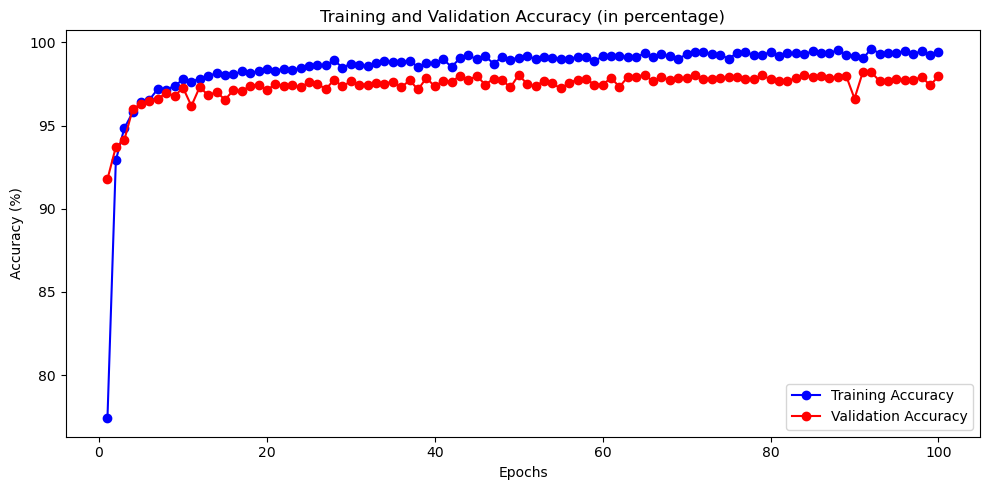

In [6]:
epochs = range(1, int(true_num_epochs) + 1)

plt.figure(figsize=(10, 5))

plt.plot(epochs, np.array(training_acc)*100, 'b-o', label='Training Accuracy')
plt.plot(epochs, np.array(validation_acc)*100, 'r-o', label='Validation Accuracy')
plt.title('Training and Validation Accuracy (in percentage)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

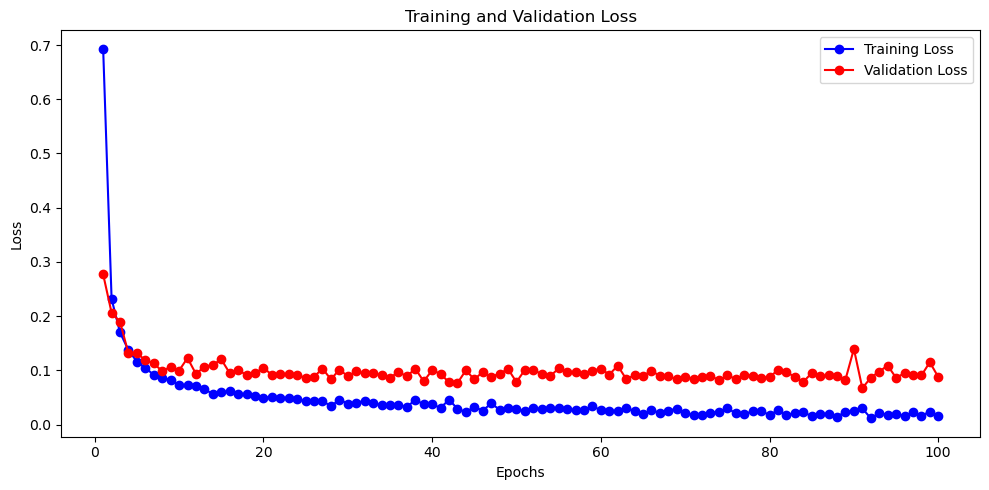

In [7]:
epochs = range(1, int(true_num_epochs) + 1)

plt.figure(figsize=(10, 5))

plt.plot(epochs, training_loss, 'b-o', label='Training Loss')
plt.plot(epochs, validation_loss, 'r-o', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

The End